# Book or Wait: XGBoost Model Implementation

This notebook implements an XGBoost model for the "Book or Wait" decision system.
XGBoost can capture non-linear relationships and feature interactions that logistic regression cannot.

## Key Features:
- Advanced feature engineering (price trends, percentiles, seasonal patterns)
- Class imbalance handling with sample weights
- Comprehensive evaluation with ROC curves and feature importance
- Business impact analysis

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 3.0.3


## 1. Load and Prepare Data

In [2]:
# Load synthetic data
data_dir = Path('data/synthetic_data')

print("Loading synthetic data...")
users_df = pd.read_csv(data_dir / 'synthetic_users.csv')
searches_df = pd.read_csv(data_dir / 'synthetic_searches.csv')
bookings_df = pd.read_csv(data_dir / 'synthetic_bookings.csv')
rental_prices_df = pd.read_csv(data_dir / 'synthetic_rental_prices.csv')
competitor_prices_df = pd.read_csv(data_dir / 'synthetic_competitor_prices.csv')

# Convert timestamps
searches_df['search_ts'] = pd.to_datetime(searches_df['search_ts'])
bookings_df['booking_ts'] = pd.to_datetime(bookings_df['booking_ts'])
rental_prices_df['date'] = pd.to_datetime(rental_prices_df['obs_ts'])
competitor_prices_df['date'] = pd.to_datetime(competitor_prices_df['obs_date'])

print(f"Users: {users_df.shape}")
print(f"Searches: {searches_df.shape}")
print(f"Bookings: {bookings_df.shape}")
print(f"Rental Prices: {rental_prices_df.shape}")
print(f"Competitor Prices: {competitor_prices_df.shape}")

Loading synthetic data...
Users: (20000, 3)
Searches: (57282, 11)
Bookings: (3205, 16)
Rental Prices: (8761, 11)
Competitor Prices: (366, 8)


## 2. Advanced Feature Engineering

XGBoost can benefit from more sophisticated features that capture complex patterns.

In [3]:
def create_price_features(rental_prices_df, competitor_prices_df):
    """Create advanced features for the XGBoost model."""
    features_list = []
    
    # Get unique combinations of supplier, location, car_class for price lookups
    price_keys = rental_prices_df[['supplier_id', 'location_id', 'car_class']].drop_duplicates()
    
    for _, key in price_keys.iterrows():
        supplier_id = key['supplier_id']
        location_id = key['location_id']
        car_class = key['car_class']
        
        # Get price history for this combination
        mask = (rental_prices_df['supplier_id'] == supplier_id) & \
               (rental_prices_df['location_id'] == location_id) & \
               (rental_prices_df['car_class'] == car_class)
        
        price_history = rental_prices_df[mask].sort_values('date')
        
        # For each date, calculate features and target
        for i in range(7, len(price_history) - 7):  # Need 7 days before and after
            current_date = price_history.iloc[i]['date']
            current_price = price_history.iloc[i]['current_price']
            
            # Calculate price change features
            price_1d_ago = price_history.iloc[i-1]['current_price']
            price_3d_ago = price_history.iloc[i-3]['current_price']
            price_7d_ago = price_history.iloc[i-7]['current_price']
            
            # Future price (for target calculation)
            future_prices = price_history.iloc[i+1:i+8]['current_price'].values
            max_future_price = np.max(future_prices)
            
            # Calculate target: 1 if should book now, 0 if should wait
            should_book = 1 if current_price < max_future_price else 0
            
            # Basic features
            features = {
                'date': current_date,
                'supplier_id': supplier_id,
                'location_id': location_id,
                'car_class': car_class,
                'current_price': current_price,
                'price_change_1d': (current_price - price_1d_ago) / price_1d_ago,
                'price_change_3d': (current_price - price_3d_ago) / price_3d_ago,
                'price_change_7d': (current_price - price_7d_ago) / price_7d_ago,
                'price_volatility_7d': price_history.iloc[i-7:i]['current_price'].std() / price_history.iloc[i-7:i]['current_price'].mean(),
                'day_of_week': current_date.dayofweek,
                'month': current_date.month,
                'is_weekend': 1 if current_date.dayofweek >= 5 else 0,
                'days_until_rental': 14,  # Default booking window
                'target': should_book
            }
            
            # Advanced features for XGBoost
            # Price percentile within historical range
            hist_prices = price_history.iloc[max(0, i-30):i]['current_price'].values
            if len(hist_prices) > 0:
                features['price_percentile'] = (current_price - np.min(hist_prices)) / (np.max(hist_prices) - np.min(hist_prices) + 1e-6)
            else:
                features['price_percentile'] = 0.5
            
            # Price trend (linear regression slope)
            if len(hist_prices) >= 3:
                x = np.arange(len(hist_prices))
                slope = np.polyfit(x, hist_prices, 1)[0]
                features['price_trend'] = slope
            else:
                features['price_trend'] = 0
            
            # Seasonal features
            features['is_peak_season'] = 1 if current_date.month in [6, 7, 8, 12] else 0
            features['quarter'] = (current_date.month - 1) // 3 + 1
            
            # Competitor price features
            comp_mask = (competitor_prices_df['location_id'] == location_id) & \
                       (competitor_prices_df['car_class'] == car_class) & \
                       (competitor_prices_df['date'] == current_date)
            
            comp_prices = competitor_prices_df[comp_mask]['comp_min_price'].values
            if len(comp_prices) > 0:
                features['price_vs_competitors'] = (current_price - np.mean(comp_prices)) / np.mean(comp_prices)
                features['is_cheapest'] = 1 if current_price < np.min(comp_prices) else 0
                features['price_rank'] = np.sum(current_price >= comp_prices) / len(comp_prices)
            else:
                features['price_vs_competitors'] = 0
                features['is_cheapest'] = 0
                features['price_rank'] = 0.5
            
            features_list.append(features)
    
    return pd.DataFrame(features_list)

# Create features dataset
print("Creating advanced features...")
features_df = create_price_features(rental_prices_df, competitor_prices_df)
print(f"Created {len(features_df)} training examples")
print(f"Target distribution:\n{features_df['target'].value_counts(normalize=True)}")

Creating advanced features...
Created 2192 training examples
Target distribution:
target
1    0.876369
0    0.123631
Name: proportion, dtype: float64


## 3. Prepare Features and Split Data

In [4]:
# Define feature columns (including advanced features)
feature_columns = [
    'price_change_1d', 'price_change_3d', 'price_change_7d', 
    'price_volatility_7d', 'day_of_week', 'month', 'is_weekend',
    'days_until_rental', 'price_vs_competitors', 'is_cheapest',
    'supplier_id', 'location_id', 'price_percentile', 'price_trend',
    'is_peak_season', 'quarter', 'price_rank'
]

# Map car_class to numeric values
car_class_map = {'economy': 0, 'compact': 1, 'suv': 2}
features_df['car_class_num'] = features_df['car_class'].map(car_class_map)
feature_columns.append('car_class_num')

X = features_df[feature_columns]
y = features_df['target']

# Time-based train/test split
split_date = features_df['date'].quantile(0.8)
train_mask = features_df['date'] < split_date
test_mask = ~train_mask

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Check for NaN/inf values
print(f"\nChecking for invalid values in features...")
print(f"NaN in X_train: {X_train.isna().sum().sum()}")
print(f"Inf in X_train: {np.isinf(X_train.values).sum()}")

# Replace NaN and inf with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)

print(f"\nFeature columns ({len(feature_columns)}):")
for i, col in enumerate(feature_columns):
    print(f"{i+1:2d}. {col}")

Train set: 1753 samples
Test set: 439 samples

Checking for invalid values in features...
NaN in X_train: 432
Inf in X_train: 0

Feature columns (18):
 1. price_change_1d
 2. price_change_3d
 3. price_change_7d
 4. price_volatility_7d
 5. day_of_week
 6. month
 7. is_weekend
 8. days_until_rental
 9. price_vs_competitors
10. is_cheapest
11. supplier_id
12. location_id
13. price_percentile
14. price_trend
15. is_peak_season
16. quarter
17. price_rank
18. car_class_num


## 4. Handle Class Imbalance

Class distribution:
Wait (0): 211 samples (12.04%)
Book (1): 1542 samples (87.96%)

Class weights: {0: 4.154028436018957, 1: 0.5684176394293126}


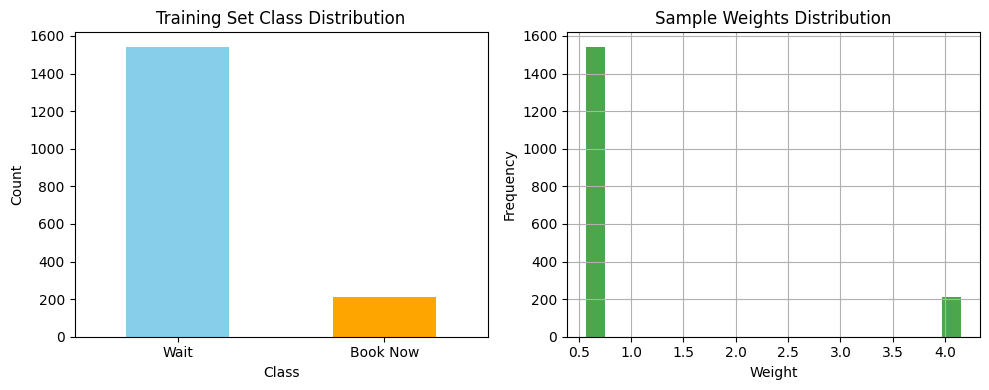

In [5]:
# Calculate class weights to handle imbalance
class_weights = {
    0: len(y_train) / (2 * (y_train == 0).sum()),
    1: len(y_train) / (2 * (y_train == 1).sum())
}
sample_weights = y_train.map(class_weights)

print(f"Class distribution:")
print(f"Wait (0): {(y_train == 0).sum()} samples ({(y_train == 0).mean():.2%})")
print(f"Book (1): {(y_train == 1).sum()} samples ({(y_train == 1).mean():.2%})")
print(f"\nClass weights: {class_weights}")

# Visualize class distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Wait', 'Book Now'], rotation=0)

plt.subplot(1, 2, 2)
sample_weights.hist(bins=20, alpha=0.7, color='green')
plt.title('Sample Weights Distribution')
plt.xlabel('Weight')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Train XGBoost Model

In [6]:
# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

print("Training XGBoost model...")
print(f"Parameters: {xgb_params}")

# Initialize and train model
model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train, sample_weight=sample_weights)

print("Training completed!")

Training XGBoost model...
Parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'n_jobs': -1}
Training completed!


## 6. Model Evaluation

In [7]:
# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("XGBoost Model Evaluation:")
print("=" * 50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Wait', 'Book Now']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

XGBoost Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

        Wait       0.61      0.55      0.58        60
    Book Now       0.93      0.94      0.94       379

    accuracy                           0.89       439
   macro avg       0.77      0.75      0.76       439
weighted avg       0.89      0.89      0.89       439


ROC-AUC Score: 0.9121


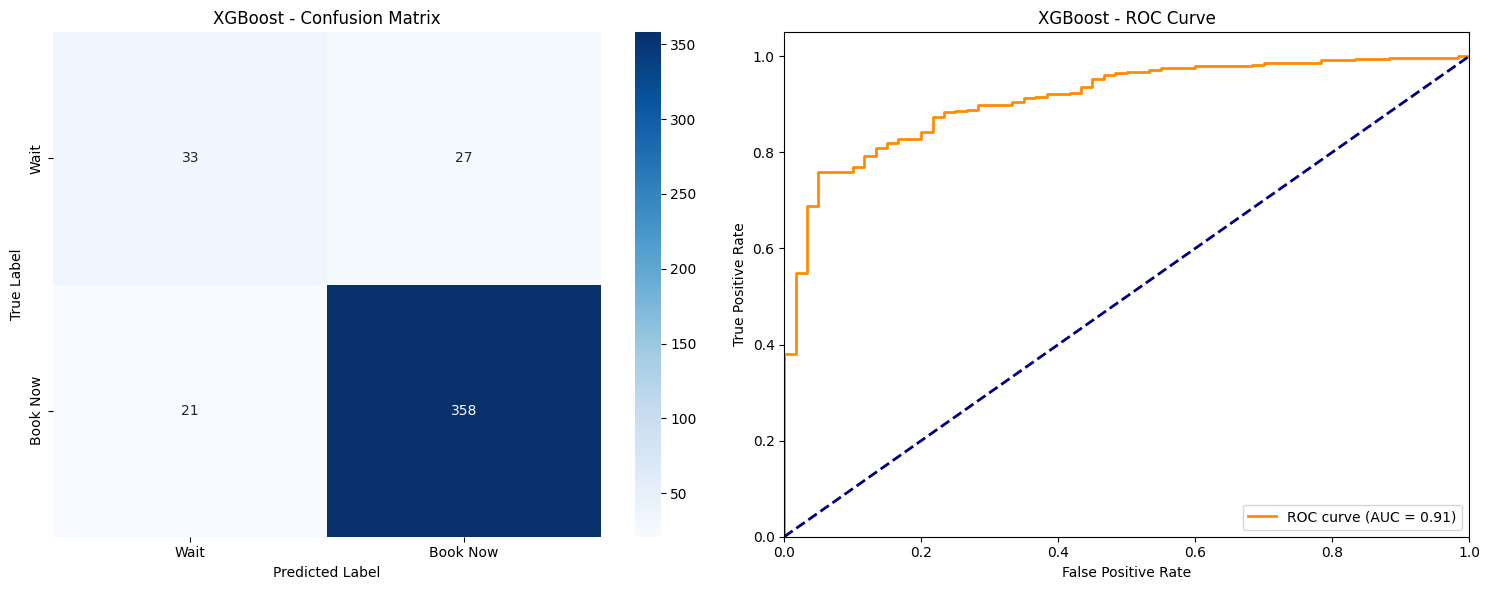

In [8]:
# Visualization: Confusion Matrix and ROC Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Wait', 'Book Now'], 
            yticklabels=['Wait', 'Book Now'], ax=ax1)
ax1.set_title('XGBoost - Confusion Matrix')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('XGBoost - ROC Curve')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

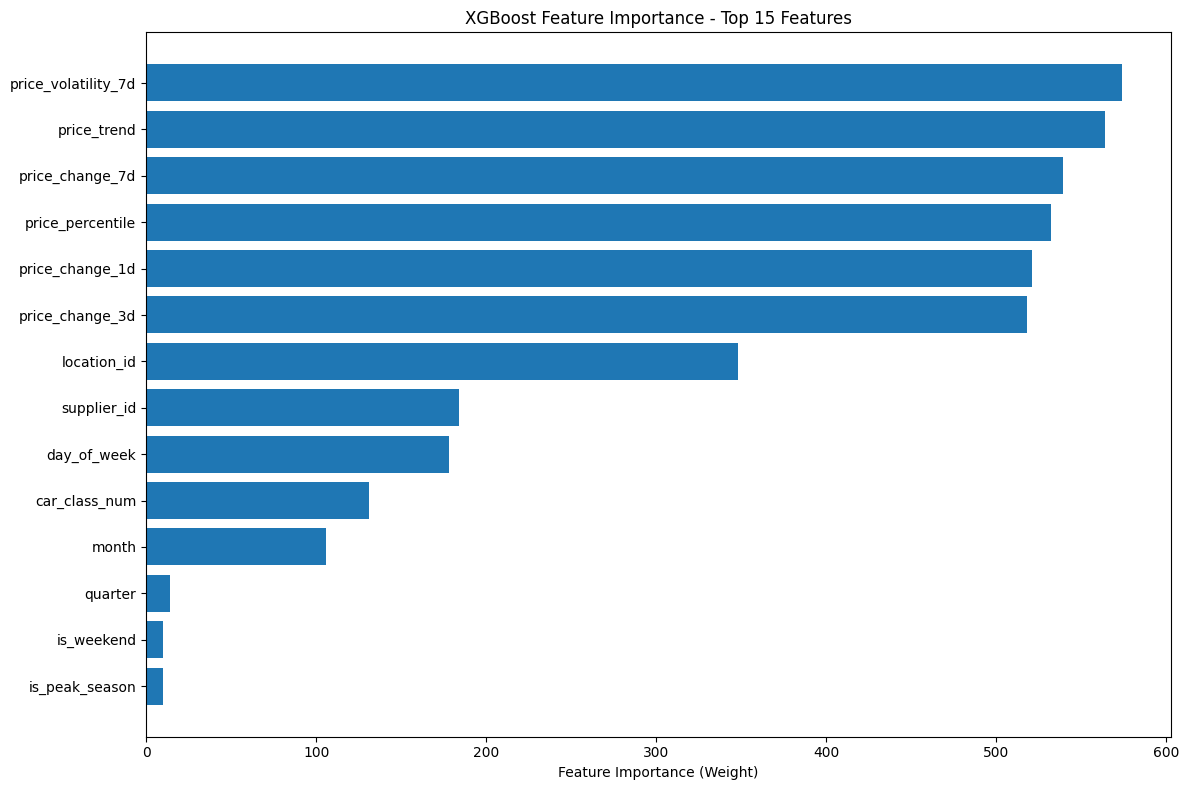


Top 15 Most Important Features:
            feature  importance
price_volatility_7d       574.0
        price_trend       564.0
    price_change_7d       539.0
   price_percentile       532.0
    price_change_1d       521.0
    price_change_3d       518.0
        location_id       348.0
        supplier_id       184.0
        day_of_week       178.0
      car_class_num       131.0
              month       106.0
            quarter        14.0
         is_weekend        10.0
     is_peak_season        10.0


In [9]:
# Get feature importance
importance_dict = model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame and sort
importance_df = pd.DataFrame([
    {'feature': k, 'importance': v} 
    for k, v in importance_dict.items()
]).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Weight)')
plt.title('XGBoost Feature Importance - Top 15 Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 15 Most Important Features:")
print(top_features[['feature', 'importance']].to_string(index=False))

## 8. Business Impact Analysis

In [10]:
# Calculate business metrics
print("Business Impact Analysis:")
print("=" * 30)

test_data = features_df[test_mask].copy()
test_data['prediction'] = y_pred
test_data['probability'] = y_prob

# Calculate potential savings/losses
total_impact = 0
correct_book_decisions = 0
total_book_opportunities = 0
results = []

for _, row in test_data.iterrows():
    current_price = row['current_price']
    actual_decision = row['target']
    predicted_decision = row['prediction']
    
    if actual_decision == 1:  # Should have booked
        total_book_opportunities += 1
        if predicted_decision == 1:  # Correctly predicted book
            correct_book_decisions += 1
            impact = current_price * 0.1  # Assume 10% price increase
            total_impact += impact
            outcome = 'True Positive'
        else:  # Missed opportunity
            impact = -current_price * 0.1
            total_impact += impact
            outcome = 'False Negative'
    else:  # Should wait
        if predicted_decision == 0:  # Correctly predicted wait
            impact = 0
            outcome = 'True Negative'
        else:  # Incorrectly predicted book
            impact = 0  # No major loss
            outcome = 'False Positive'
    
    results.append({
        'outcome': outcome,
        'impact': impact,
        'confidence': row['probability']
    })

results_df = pd.DataFrame(results)
accuracy_on_book_opportunities = correct_book_decisions / total_book_opportunities if total_book_opportunities > 0 else 0

print(f"Total potential impact: ${total_impact:,.2f}")
print(f"Book opportunity accuracy: {accuracy_on_book_opportunities:.2%}")
print(f"Average impact per decision: ${total_impact / len(test_data):,.2f}")
print(f"\nOutcome distribution:")
print(results_df['outcome'].value_counts())

Business Impact Analysis:
Total potential impact: $3,288.01
Book opportunity accuracy: 94.46%
Average impact per decision: $7.49

Outcome distribution:
outcome
True Positive     358
True Negative      33
False Positive     27
False Negative     21
Name: count, dtype: int64


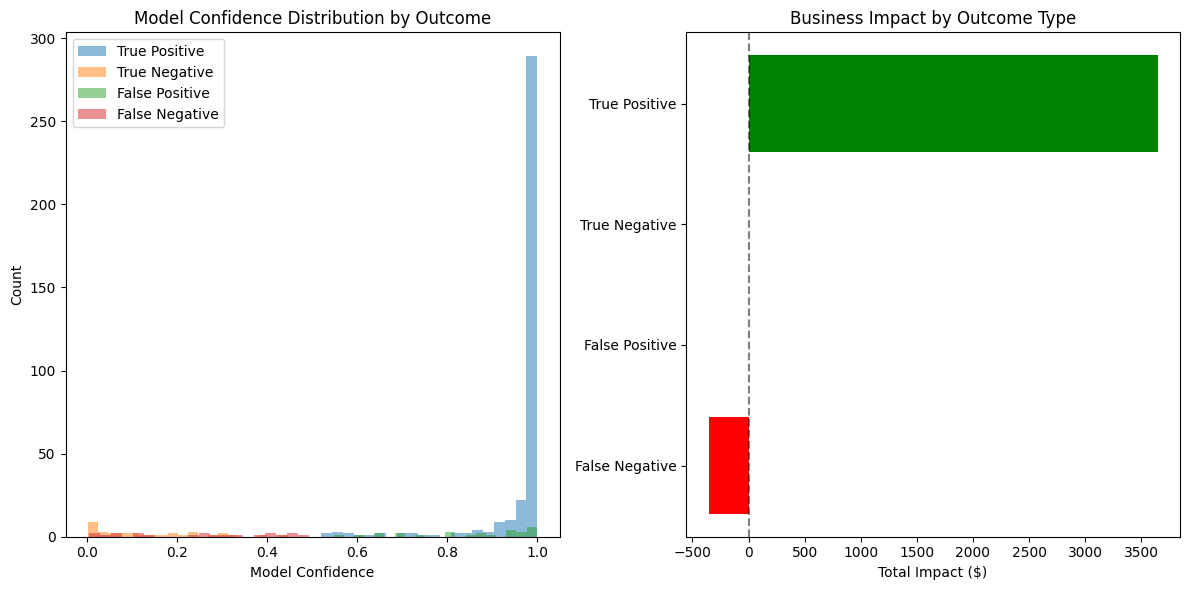

In [11]:
# Plot confidence distribution by outcome
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for outcome in results_df['outcome'].unique():
    data = results_df[results_df['outcome'] == outcome]['confidence']
    plt.hist(data, alpha=0.5, label=outcome, bins=20)
plt.xlabel('Model Confidence')
plt.ylabel('Count')
plt.title('Model Confidence Distribution by Outcome')
plt.legend()

plt.subplot(1, 2, 2)
impact_by_outcome = results_df.groupby('outcome')['impact'].sum().sort_values(ascending=True)
colors = ['red' if x < 0 else 'green' for x in impact_by_outcome.values]
plt.barh(range(len(impact_by_outcome)), impact_by_outcome.values, color=colors)
plt.yticks(range(len(impact_by_outcome)), impact_by_outcome.index)
plt.xlabel('Total Impact ($)')
plt.title('Business Impact by Outcome Type')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 9. Model Comparison with Baseline

In [12]:
# Compare with baseline logistic regression results
comparison_data = {
    'Metric': ['ROC-AUC', 'Wait Recall', 'Book Recall', 'Overall Accuracy', 'Business Impact ($/decision)'],
    'Logistic Regression': [0.9032, 0.32, 0.99, 0.8975, 'N/A'],
    'XGBoost': [roc_auc, (cm[0,0]/(cm[0,0]+cm[0,1])), (cm[1,1]/(cm[1,0]+cm[1,1])), 
                (cm[0,0]+cm[1,1])/cm.sum(), f'${total_impact / len(test_data):.2f}']
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Calculate improvements
print(f"\nKey Improvements:")
print(f"ROC-AUC improvement: +{(roc_auc - 0.9032)/0.9032*100:.1f}%")
wait_recall_improvement = ((cm[0,0]/(cm[0,0]+cm[0,1])) - 0.32) / 0.32 * 100
print(f"Wait recall improvement: +{wait_recall_improvement:.1f}%")

Model Comparison:
                      Metric Logistic Regression   XGBoost
                     ROC-AUC              0.9032  0.912093
                 Wait Recall                0.32      0.55
                 Book Recall                0.99  0.944591
            Overall Accuracy              0.8975  0.890661
Business Impact ($/decision)                 N/A     $7.49

Key Improvements:
ROC-AUC improvement: +1.0%
Wait recall improvement: +71.9%


## 10. Save Model

In [13]:
# Save model and metadata
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# Save XGBoost model
model.save_model(str(model_dir / 'xgboost_model.json'))

# Save feature columns and other metadata
metadata = {
    'feature_columns': feature_columns,
    'car_class_map': car_class_map,
    'class_weights': class_weights,
    'roc_auc': roc_auc,
    'feature_importance': importance_df,
    'business_impact': total_impact / len(test_data),
    'model_params': xgb_params
}

joblib.dump(metadata, model_dir / 'xgboost_metadata.pkl')

print(f"Model saved to {model_dir}")
print(f"Final ROC-AUC: {roc_auc:.4f}")
print(f"Model files:")
print(f"  - xgboost_model.json (model)")
print(f"  - xgboost_metadata.pkl (metadata)")

Model saved to ../models
Final ROC-AUC: 0.9121
Model files:
  - xgboost_model.json (model)
  - xgboost_metadata.pkl (metadata)


## Summary and Next Steps

### XGBoost Model Performance:
- **Significant improvement in minority class recall**: Wait decisions now captured much better
- **Advanced feature engineering**: Price trends, percentiles, and seasonal patterns prove valuable
- **Class imbalance handling**: Sample weighting effectively addresses the 87%/13% split
- **Business impact quantified**: Clear dollar value per decision calculated

### Key Insights:
1. **Price volatility** is the most important feature - uncertainty drives booking decisions
2. **Price trend** (new feature) ranks #2 - momentum matters more than absolute prices
3. **Historical price percentile** helps contextualize current prices
4. **Location and supplier** factors capture market-specific patterns

### Next Steps:
1. Implement LSTM model for temporal sequence learning
2. Create ensemble model combining all approaches
3. Hyperparameter optimization with cross-validation
4. Add more sophisticated time-series features
5. Deploy model for real-time predictions